In [1]:
from pathlib import Path

from data_scripts import get_newest_data_paths
from mandel_solvers import make_mandel_solver_space

from solver_selector.simulation_runner import make_simulation_runner

path = Path().parent / "../2"
load_data_paths = []
# load_data_paths += get_newest_data_paths(path / "poro_coldstart_s", n_newest=1)
# load_data_paths += get_newest_data_paths(path / '../3.1/poro_gp', n_newest=1)
load_data_paths += ['../3.1/performance/poro_gp_2.npy']
# load_data_paths += get_newest_data_paths(path / "poro_coldstart_m", n_newest=1)
# load_data_paths += get_newest_data_paths('poro_coldstart_gp', n_newest=1)

# assert len(load_data_paths) == 3

solver_space = make_mandel_solver_space(l_factor="dynamic")

In [2]:
simulation_runner = make_simulation_runner(
    solver_space=solver_space,
    params={
        "load_statistics_paths": load_data_paths,
        "print_solver": True,
        "predictor": "gaussian_process",
        # 'regressor': 'mlp',

    },
)

Selecting from 1 solvers.
0 gmres - splitting_fixed_stress [primary - direct, secondary - direct, l_factor=0, primary_variable, method]
Using Gaussian process, exploration: 0.1
Warm start using data:
../3.1/performance/poro_gp_2.npy


/home/firedrake/workspace/porepy_workspace/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore
/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [3]:
import pandas as pd
import numpy as np

predictor = simulation_runner.solver_selector.predictors[0]
X = np.array(predictor.memory_contexts)
y = np.array(predictor.memory_rewards)

data = pd.DataFrame(X, columns=['ts', 'ms', 'cfl_mean', 'cfl_max', 'l_factor'])
data['target'] = y
data.describe()

,ts,ms,cfl_mean,cfl_max,l_factor,target
count,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000
mean,2.302585,8.884333e+00,4.759038,2.667713,0.625263,0.992424
std,0.000000,1.785306e-15,0.655398,0.066279,0.332222,0.137809
min,2.302585,8.884333e+00,4.250726,2.650625,0.000000,0.618352
25%,2.302585,8.884333e+00,4.380052,2.653065,0.578947,0.883789
50%,2.302585,8.884333e+00,4.566683,2.658592,0.631579,0.998754
75%,2.302585,8.884333e+00,4.896787,2.664442,1.000000,1.128943
max,2.302585,8.884333e+00,9.158445,3.302602,1.000000,1.173742


In [4]:
ts_mean = data.ts.mean()
# data_max = data.ms.max() + (data.ms.max() - data.ms.min())
data_max = data.ms.max()
ms = np.linspace(data.ms.min(), data_max, 100)
cfl_mean = data.cfl_mean.mean()
cfl_max = data.cfl_max.mean()
l_factor = np.linspace(data.l_factor.min(), data.l_factor.max(), 100)

ms, l_factor = np.meshgrid(ms, l_factor, indexing='ij')

data1 = np.zeros((5, 100, 100))
data1[0] = ts_mean
data1[1] = ms
data1[2] = cfl_mean
data1[3] = cfl_max
data1[4] = l_factor
data1 = data1.reshape(5, -1)
data1 = data1.T

target1 = predictor.regressor.predict(data1)
df1 = pd.DataFrame(data1, columns=['ts', 'ms', 'cfl_mean', 'cfl_max', 'l_factor'])
df1['target'] = target1

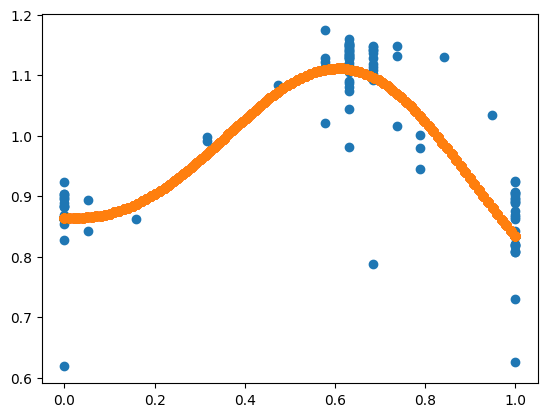

In [5]:
from matplotlib import pyplot as plt

plt.scatter(data['l_factor'], data['target'])
plt.scatter(df1['l_factor'], df1['target'])

In [ ]:
# mean, std = predictor.regressor.predict(data1, return_std=True)
# df1['target'] = mean + std

In [ ]:
from dash_app import make_app

app = make_app([data, df1], ['ms', 'l_factor', 'target'])

In [ ]:
import torch
import gpytorch


class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=5)
            + gpytorch.kernels.LinearKernel(active_dims=[1])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# initialize likelihood and model
predictor = simulation_runner.solver_selector.predictors[0]
X = torch.Tensor(predictor.memory_contexts)
y = torch.Tensor(predictor.memory_rewards)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X, y, likelihood)

In [ ]:
# this is for running the notebook in our testing framework
training_iter = 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X)
    # Calc loss and backprop gradients
    loss = -mll(output, y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        # model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

/home/firedrake/firedrake/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-06 to the diagonal



Iter 1/100 - Loss: 0.821   noise: 0.693
Iter 2/100 - Loss: 0.782   noise: 0.644
Iter 3/100 - Loss: 0.743   noise: 0.598
Iter 4/100 - Loss: 0.702   noise: 0.554
Iter 5/100 - Loss: 0.662   noise: 0.513
Iter 6/100 - Loss: 0.620   noise: 0.474
Iter 7/100 - Loss: 0.578   noise: 0.437
Iter 8/100 - Loss: 0.535   noise: 0.403
Iter 9/100 - Loss: 0.492   noise: 0.370
Iter 10/100 - Loss: 0.448   noise: 0.340
Iter 11/100 - Loss: 0.404   noise: 0.312
Iter 12/100 - Loss: 0.359   noise: 0.286
Iter 13/100 - Loss: 0.313   noise: 0.261
Iter 14/100 - Loss: 0.267   noise: 0.239
Iter 15/100 - Loss: 0.221   noise: 0.218
Iter 16/100 - Loss: 0.174   noise: 0.198
Iter 17/100 - Loss: 0.126   noise: 0.181
Iter 18/100 - Loss: 0.078   noise: 0.164
Iter 19/100 - Loss: 0.030   noise: 0.149
Iter 20/100 - Loss: -0.019   noise: 0.136
Iter 21/100 - Loss: -0.067   noise: 0.123
Iter 22/100 - Loss: -0.116   noise: 0.111
Iter 23/100 - Loss: -0.166   noise: 0.101
Iter 24/100 - Loss: -0.215   noise: 0.091
Iter 25/100 - Loss: 